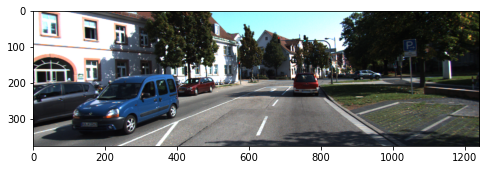

In [68]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 24 12:38:17 2018
The KITTI is one of the well known benchmarks for 3D Object detection. Working 
on this dataset requires some understanding of what the different files and their
contnts are. In this piece we use  4 different types of files used from the 
KITTI 3D Objection Detection dataset as follows to do some basic manipulation 
and sanity checks to get basic underdstanding. 
 camera2 image (.png), 
 camera2 label label (.txt),
 calibration (.txt), 
 velodyne point cloud (.bin),
Codes to project 3D data from  camera co-ordinate and velodyne coordinate to  
camera image.  The goal is to see if the  data along with appropriate geometry 
matrices are handled correctly.  2 different types of images are generated - 
camera2 image and bird's eye view of point cloud.  
@author: sg
Refs :
  1. Vision meets Robotics: The KITTI Dataset - http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
  2. 3D Object Detection Evaluation 2017 - http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d
  3. Download left color images of object data set (12 GB) - http://www.cvlibs.net/download.php?file=data_object_image_2.zip
  4. Download Velodyne point clouds, if you want to use laser information (29 GB) - http://www.cvlibs.net/download.php?file=data_object_velodyne.zip
  5. Download camera calibration matrices of object data set (16 MB) - http://www.cvlibs.net/download.php?file=data_object_calib.zip
  6. Download training labels of object data set (5 MB) - http://www.cvlibs.net/download.php?file=data_object_label_2.zip
  7. Download object development kit (1 MB) (including 3D object detection and bird's eye view evaluation code) - http://kitti.is.tue.mpg.de/kitti/devkit_object.zip
  
"""

import os
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from   matplotlib.path import Path
from matplotlib import colors
import numpy as np
from PIL import Image
from math import sin, cos
import argparse


basedir = 'C:\sabeeha\KITTI\KITTI_O' # windows
# basedir = '../data.2/object/training' # *nix
# basedir = 'data' # *nix
left_cam_rgb= 'image_2'
label = 'label_2'
velodyne = 'velodyne'
calib = 'calib'


def loadKittiFiles (frame) :
  '''
  Load KITTI image (.png), calibration (.txt), velodyne (.bin), and label (.txt),  files
  corresponding to a shot.
  Args:
    frame :  name of the shot , which will be appended to externsions to load
                the appropriate file.
  '''
  # load image file 
  fn = basedir+ left_cam_rgb + frame+'.png'
  fn = os.path.join(basedir, left_cam_rgb, frame+'.png')
  left_cam = Image.open(fn).convert ('RGB')
  
#   # load velodyne file 
#   fn = basedir+ velodyne + frame+'.bin'
#   fn = os.path.join(basedir, velodyne, frame+'.bin')
#   velo = np.fromfile(fn, dtype=np.float32).reshape(-1, 4)
  
  # load calibration file
  fn = basedir+ calib + frame+'.txt'
  fn = os.path.join(basedir, calib, frame+'.txt')
  calib_data = {}
  with open (fn, 'r') as f :
    for line in f.readlines():
      if ':' in line :
        key, value = line.split(':', 1)
        calib_data[key] = np.array([float(x) for x in value.split()])
  
  # load label file
  fn = basedir+ label + frame+'.txt'
  fn = os.path.join(basedir, label, frame+'.txt')
  label_data = {}
  with open (fn, 'r') as f :
    for line in f.readlines():
      if len(line) > 3:
        key, value = line.split(' ', 1)
        #print ('key', key, 'value', value)
        if key in label_data.keys() :
          label_data[key].append([float(x) for x in value.split()] )
        else:
          label_data[key] =[[float(x) for x in value.split()]]

  for key in label_data.keys():
    label_data[key] = np.array( label_data[key])
    
  return left_cam, label_data, calib_data



def computeBox3D(label, P):
  '''
  takes an object label and a projection matrix (P) and projects the 3D
  bounding box into the image plane.
  
  (Adapted from devkit_object/matlab/computeBox3D.m)
  
  Args:
    label -  object label list or array
  '''
  w = label[7]
  h = label[8]
  l = label[9]
  x = label[10]
  y = label[11]
  z = label[12]
  ry = label[13]
  
  # compute rotational matrix around yaw axis
  R = np.array([ [+cos(ry), 0, +sin(ry)],
                 [0, 1,               0],
                 [-sin(ry), 0, +cos(ry)] ] )

  # 3D bounding box corners

  x_corners = [0, l, l, l, l, 0, 0, 0] # -l/2
  y_corners = [0, 0, h, h, 0, 0, h, h] # -h
  z_corners = [0, 0, 0, w, w, w, w, 0] # --w/2
  
  x_corners += -l/2
  y_corners += -h
  z_corners += -w/2
  
  
  # bounding box in object co-ordinate
  corners_3D = np.array([x_corners, y_corners, z_corners])
  #print ( 'corners_3d', corners_3D.shape, corners_3D)
  
  # rotate 
  corners_3D = R.dot(corners_3D)
  #print ( 'corners_3d', corners_3D.shape, corners_3D)
  
  #translate 
  corners_3D += np.array([x, y, z]).reshape((3,1))
  #print ( 'corners_3d', corners_3D)
  
  corners_3D_1 = np.vstack((corners_3D,np.ones((corners_3D.shape[-1]))))
  corners_2D = P.dot (corners_3D_1)
  corners_2D = corners_2D/corners_2D[2]
  
  # edges, lines 3d/2d bounding box in vertex index 
  edges = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,0], [0,5], [1,4], [2,7], [3, 6]]
  lines = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,0], [0,5], [5, 4], [4, 1], [1,2], [2,7], [7,6], [6,3]]
  bb3d_lines_verts_idx = [0,1,2,3,4,5,6,7,0,5,4,1,2,7,6,3]
  
  bb2d_lines_verts = corners_2D[:,bb3d_lines_verts_idx] # 
   
  return corners_2D[:2], corners_3D, bb2d_lines_verts[:2]
  
  
  
 
def labelToBoundingBox(ax, labeld, calibd):
  '''
  Draw 2D and 3D bpunding boxes.  
  
  Each label  file contains the following ( copied from devkit_object/matlab/readLabels.m)
  #  % extract label, truncation, occlusion
  #  lbl = C{1}(o);                   % for converting: cell -> string
  #  objects(o).type       = lbl{1};  % 'Car', 'Pedestrian', ...
  #  objects(o).truncation = C{2}(o); % truncated pixel ratio ([0..1])
  #  objects(o).occlusion  = C{3}(o); % 0 = visible, 1 = partly occluded, 2 = fully occluded, 3 = unknown
  #  objects(o).alpha      = C{4}(o); % object observation angle ([-pi..pi])
  #
  #  % extract 2D bounding box in 0-based coordinates
  #  objects(o).x1 = C{5}(o); % left   -> in pixel
  #  objects(o).y1 = C{6}(o); % top
  #  objects(o).x2 = C{7}(o); % right
  #  objects(o).y2 = C{8}(o); % bottom
  #
  #  % extract 3D bounding box information
  #  objects(o).h    = C{9} (o); % box width    -> in object coordinate
  #  objects(o).w    = C{10}(o); % box height
  #  objects(o).l    = C{11}(o); % box length
  #  objects(o).t(1) = C{12}(o); % location (x) -> in camera coordinate 
  #  objects(o).t(2) = C{13}(o); % location (y)
  #  objects(o).t(3) = C{14}(o); % location (z)
  #  objects(o).ry   = C{15}(o); % yaw angle  -> rotation aroun the y/vetical axis
  '''
  # 

  P2_rect = calibd['P2'].reshape(3,4)
  #print('P2_rect', P2_rect)
  
  bb3d = []
#   bb2d = []
  
  for key in labeld.keys ():
    
    color = 'white'
    if key == 'Car':
      color = 'red'
    elif key == 'Pedestrian':
      color = 'pink'
    elif key == 'Cyclist':
      color = 'purple'
    elif key == 'DontCare':
      color = 'white'
    
   

      #3D
      w3d = labeld[key][o][7]
      h3d = labeld[key][o][8]
      l3d = labeld[key][o][9]
      x3d = labeld[key][o][10]
      y3d = labeld[key][o][11]
      z3d = labeld[key][o][12]
      yaw3d = labeld[key][o][13]
      
   
      if key != 'DontCare' :
        
        corners_2D, corners_3D, paths_2D = computeBox3D(labeld[key][o], P2_rect)
        verts = paths_2D.T # corners_2D.T
        codes = [Path.LINETO]*verts.shape[0]
        codes[0] = Path.MOVETO
        pth  = Path (verts, codes)
        p = patches.PathPatch( pth, fill=False, color='purple', linewidth=2)
        ax.add_patch(p)
        
  
  return np.array(bb3d)


def main (frame='00000326'):
  """
  Completes the plots 
  """
  left_cam, label_data, calib_data = loadKittiFiles(frame)
  
  f = plt.figure(figsize=plt.figaspect(0.5))
  
  # show the left camera image 
  ax = f.add_subplot(1,1,1,)
#   ax.imshow(left_cam)

  
  
  bb3d = labelToBoundingBox(ax, label_data, calib_data)
  #print ('bb3d', bb3d)

  ax.imshow(left_cam)

  # point cloud to bird's eye view scatter plot
#   ax2 = f.add_subplot(2,1,1, )#projection="3d" )
#   pointCloudToBirdsEyeView(ax2, velo, bb3d)

  
  #plt.show()


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--frame', type=str,
                      default='0000000326',
                      help='frame name without extension')
  FLAGS, unparsed = parser.parse_known_args()
  #print ('FLAGS', FLAGS)
  main(frame=FLAGS.frame)



type <class 'numpy.ndarray'>


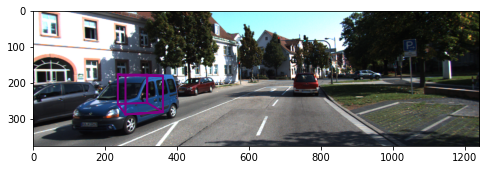

In [13]:

import os
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from   matplotlib.path import Path
from matplotlib import colors
import numpy as np
from PIL import Image
from math import sin, cos
def computeBox3D(ax,label, P):
  '''
  takes an object label and a projection matrix (P) and projects the 3D
  bounding box into the image plane.
  
  (Adapted from devkit_object/matlab/computeBox3D.m)
  
  Args:
    label -  object label list or array
  '''
  label = np.array([float(x) for x in label])
  label = np.around(label,2)
  P = np.array([float(x) for x in P])
  P = np.reshape(P,(3,4))
  
  w = label[0]
  h = label[1]
  l = label[2]
  x = label[3]
  y = label[4]
  z = label[5]
  ry = label[6]
  
  # compute rotational matrix around yaw axis
  R = np.array([ [+cos(ry), 0, +sin(ry)],
                 [0, 1,               0],
                 [-sin(ry), 0, +cos(ry)] ] )

  # 3D bounding box corners

  x_corners = [0, l, l, l, l, 0, 0, 0] # -l/2
  y_corners = [0, 0, h, h, 0, 0, h, h] # -h
  z_corners = [0, 0, 0, w, w, w, w, 0] # --w/2
  
  x_corners += +l/2
  y_corners += -h/2
  z_corners += -w/2
  
  
  # bounding box in object co-ordinate
  corners_3D = np.array([x_corners, y_corners, z_corners])
  #print ( 'corners_3d', corners_3D.shape, corners_3D)
  
  # rotate 
  corners_3D = R.dot(corners_3D)
  
  #translate 
  corners_3D += np.array([x, y, z]).reshape((3,1))
  #print ( 'corners_3d', corners_3D)
  
  corners_3D_1 = np.vstack((corners_3D,np.ones((corners_3D.shape[-1]))))
  #print("corners_3D_1",corners_3D_1)
  print("type",(type(corners_3D_1)))
  corners_2D = P.dot(corners_3D_1)
  corners_2D = corners_2D/corners_2D[2]
  
  # edges, lines 3d/2d bounding box in vertex index 
  edges = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,0], [0,5], [1,4], [2,7], [3, 6]]
  lines = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [7,0], [0,5], [5, 4], [4, 1], [1,2], [2,7], [7,6], [6,3]]
  bb3d_lines_verts_idx = [0,1,2,3,4,5,6,7,0,5,4,1,2,7,6,3]
  
  bb2d_lines_verts = corners_2D[:,bb3d_lines_verts_idx] # 
   
  return corners_2D[:2], corners_3D, bb2d_lines_verts[:2]

P2 = [7.215377e+02, 0.000000e+00, 6.095593e+02,4.485728e+0, 10.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01,0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]
label = [1.53, 1.64, 4.06, -3.65446167, 0.99229345, 9.62, -2.12]
#label= [1.76, 1.58, 3.68, -4.14, 1.79, 9.24, 1.76]

f = plt.figure(figsize=plt.figaspect(0.5))
ax = f.add_subplot(1,1,1,)
corners_2D, corners_3D, paths_2D = computeBox3D(ax,label, P2)
verts = paths_2D.T # corners_2D.T
codes = [Path.LINETO]*verts.shape[0]
codes[0] = Path.MOVETO
pth  = Path (verts, codes)
p = patches.PathPatch( pth, fill=False, color='purple', linewidth=2)
ax.add_patch(p)

fn = "C:\\sabeeha\\KITTI\\2011_09_26_drive_0059_sync\\image_02\\data\\0000000326.png"
left_cam = Image.open(fn).convert ('RGB')


# show the left camera image 

ax.imshow(left_cam)
  

In [10]:
P2 = [7.215377e+02, 0.000000e+00, 6.095593e+02,4.485728e+0, 10.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01,0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]
P = np.array([float(x) for x in P2])
P = np.reshape(P,(3,4))
P = np.delete(P,3,axis=1)
print(P)

#label = [1.55, 1.66, 4.09, 13068.576402194305, 3531.8307916768163, 17.212147490647904, -1.39]
label =[1.55, 1.66, 4.09,13068.576402194305, 3531.8307916768163, 17.212147490647904,-1.39]
label = np.array([float(x) for x in label])
label = np.around(label,2)

P= np.linalg.inv(P) 

P1= np.matmul(P,label)
P2= P.dot(label)

print(P1)
print(P2)



[[721.5377   0.     609.5593]
 [ 10.     721.5377 172.854 ]
 [  0.       0.       1.    ]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 3)

In [28]:
import cv2
import glob
  
# Opens a image in RGB mode 
files = glob.glob(r"C:\\sabeeha\\3D\\output\\*.*") 
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('C:\\sabeeha\\3D\\output\\projection.avi', fourcc, 25.0, (365,1147))

  
# Size of the image in pixels (size of orginal image) 

for File in files:
    print(File)
    im1 = cv2.imread(File) 
    cv2.imshow(im1)
    
    vid.write(im1)

print('video saved')
vid.release()

C:\\sabeeha\\3D\\output\0000000062.png


TypeError: imshow() missing required argument 'mat' (pos 2)

In [33]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in glob.glob('C:\\sabeeha\\3D\\output\\*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('C:\\sabeeha\\3D\\output\\project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()